In [37]:
import os
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import tensorflow as tf

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

/tmp/ipykernel_32/1248802108.py:19: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [38]:
main_folder = '/kaggle/input/celeba-dataset'
images_folder = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'

EXAMPLE_PIC = images_folder + '/000005.jpg'

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20

In [39]:
df_attr = pd.read_csv('/kaggle/input/celeba-dataset/list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

In [40]:
df_attr.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [41]:
df_attr.columns

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

In [42]:
EXAMPLE_PIC

'/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000005.jpg'

Smiling    0
Male       0
Young      1
Name: 000005.jpg, dtype: int64

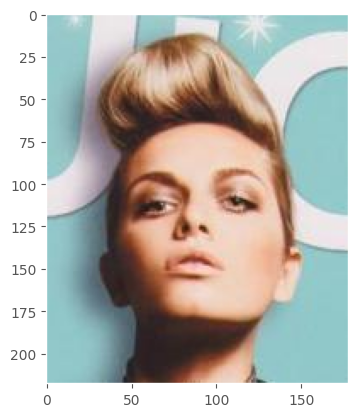

In [43]:
img = load_img(EXAMPLE_PIC)
plt.imshow(img)
plt.grid(False)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling','Male','Young']]

Text(0.5, 1.0, 'Male or Female')

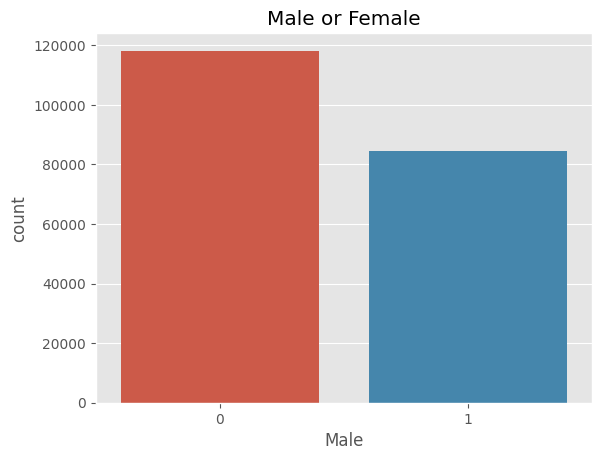

In [44]:
sns.countplot(x = 'Male',data = df_attr)
plt.title('Male or Female')

In [45]:
data_partition = pd.read_csv('/kaggle/input/celeba-dataset/list_eval_partition.csv',index_col = 'image_id')
data_partition.head()

,partition
image_id,
000001.jpg,0
000002.jpg,0
000003.jpg,0
000004.jpg,0
000005.jpg,0


<Axes: xlabel='partition', ylabel='count'>

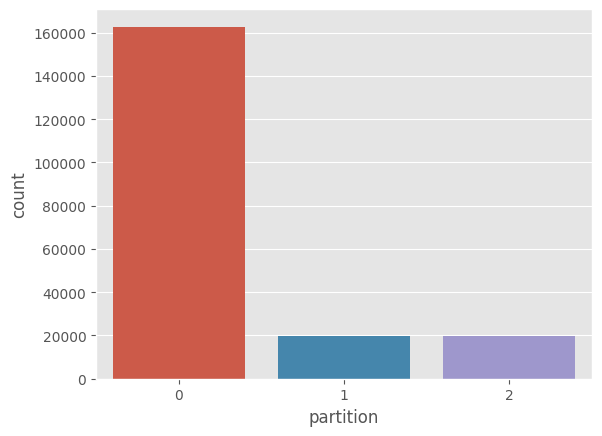

In [46]:
sns.countplot(x = 'partition',data = data_partition)

In [47]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
data_partition['partition'].value_counts().sort_index()

partition
0    162770
1     19867
2     19962
Name: count, dtype: int64

In [48]:
df_par_attr = data_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [49]:
def load_reshape_img(fname):
    if os.path.isfile(fname):
        img = load_img(fname)
        x = img_to_array(img) / 255.0
        x = np.expand_dims(x,axis=0)
        return x

# Define the generate_df function
def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,df_par_attr[(df_par_attr['partition'] == partition) & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder +'/'+ str(fname)) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder +'/'+ str(fname))
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

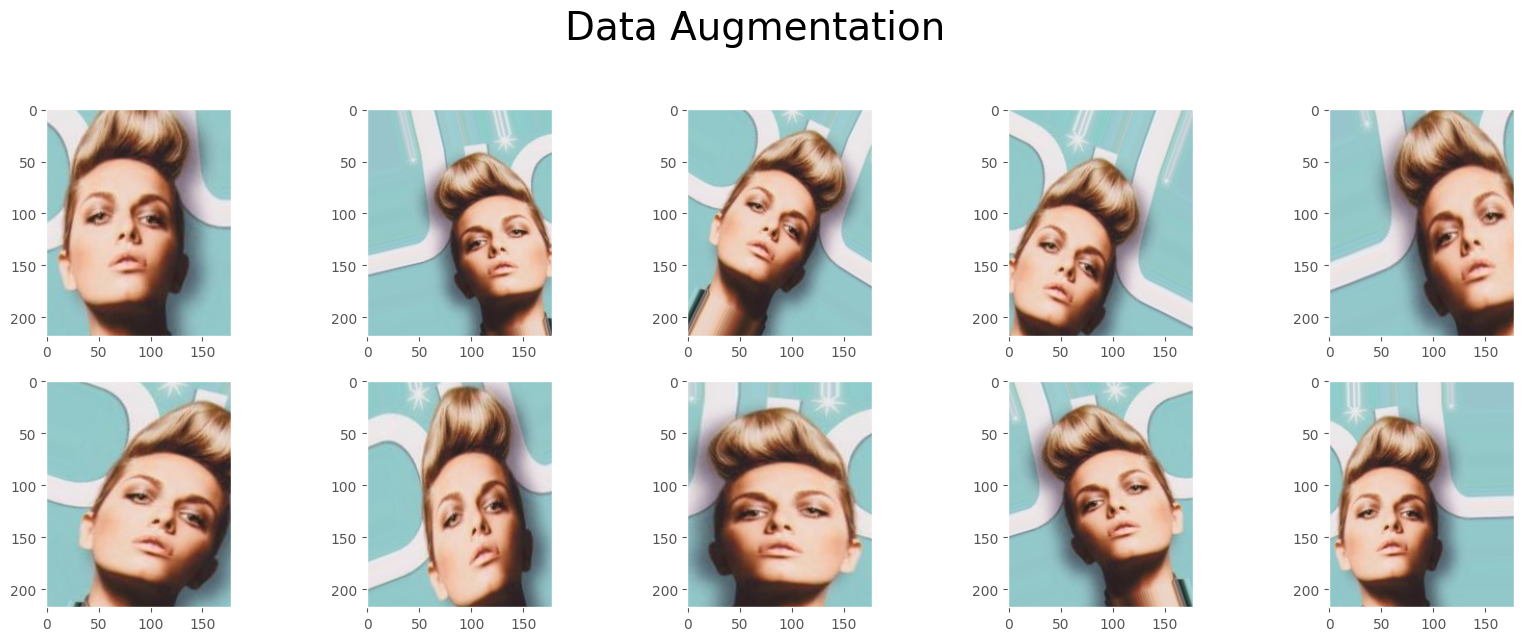

In [50]:
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

In [51]:
num_samples = 10000
BATCH_SIZE = 32 
x_train, y_train = generate_df(0, 'Male', 10000)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [52]:
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)


In [64]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3

# Define the InceptionV3 model without loading weights
inc_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))


Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/inception_v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [Errno -3] Temporary failure in name resolution

In [65]:
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [66]:
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [67]:
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', 
                               verbose=1, save_best_only=True)

In [68]:
hist = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

/tmp/ipykernel_32/1185555293.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_.fit_generator(train_generator


Epoch 1/20
313/312 [==============================] - ETA: -1s - loss: 0.7155 - accuracy: 0.5080
Epoch 1: val_loss improved from inf to 0.71716, saving model to weights.best.inc.male.hdf5
312/312 [==============================] - 1247s 4s/step - loss: 0.7155 - accuracy: 0.5080 - val_loss: 0.7172 - val_accuracy: 0.5005
Epoch 2/20
313/312 [==============================] - ETA: -1s - loss: 0.7088 - accuracy: 0.5127
Epoch 2: val_loss did not improve from 0.71716
312/312 [==============================] - 1218s 4s/step - loss: 0.7088 - accuracy: 0.5127 - val_loss: 2.0908 - val_accuracy: 0.4820
Epoch 3/20
313/312 [==============================] - ETA: -1s - loss: 0.7067 - accuracy: 0.5003
Epoch 3: val_loss did not improve from 0.71716
312/312 [==============================] - 1227s 4s/step - loss: 0.7067 - accuracy: 0.5003 - val_loss: 2.4300 - val_accuracy: 0.5095
Epoch 4/20
313/312 [==============================] - ETA: -1s - loss: 0.7007 - accuracy: 0.5137
Epoch 4: val_loss did not im

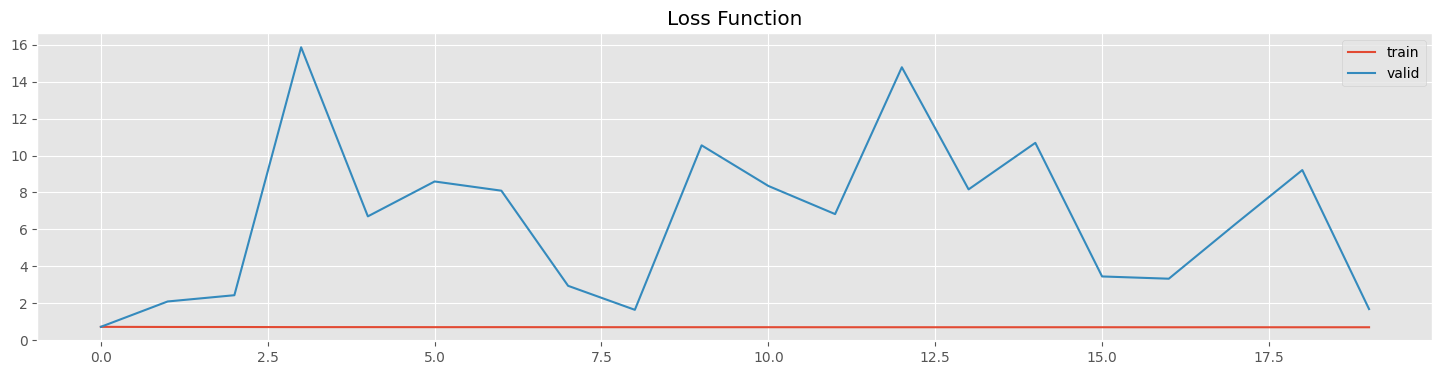

In [69]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

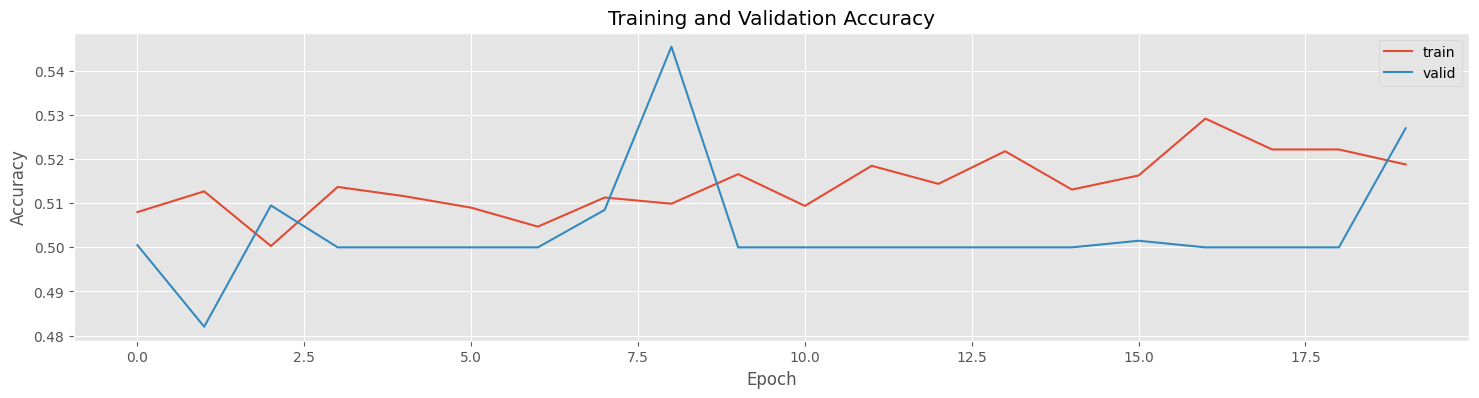

In [72]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label='train')  # Use 'accuracy' for training accuracy
plt.plot(hist.history['val_accuracy'], label='valid')  # Use 'val_accuracy' for validation accuracy
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()